<img src='https://www.iscac.pt/wp-content/uploads/2025/01/Logotipo-Horizontal-CBS-ISCAC-Color.png' width='200'>

## **Métodos de Previsão Aplicados - Trabalho da Época Normal**


> **Grupo:**
* Bernardo Silva (2020112296)
* Catarina Auxiliar (2021134297)
* Nuno Gonçalves (2015063961)
* Simão Dias (2020132169)

# _0. Preâmbulo

## _0.1. Bibliotecas

In [87]:
!pip install fredapi

In [88]:
from fredapi import Fred
fred = Fred(api_key='b26f46b92fe22451604425379371bc2a')

In [89]:
!pip install statsforecast


In [90]:

import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA, MSTL
from utilsforecast.losses import rmse, mae, mape
from utilsforecast.evaluation import evaluate
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime, timedelta
from utilsforecast.losses import rmse, mae, mape

register_matplotlib_converters()
sns.set_style("darkgrid")

## _0.2. Versão do Python e das bibliotecas

In [91]:
# versão do Python
!python --version

Python 3.11.11


In [92]:
# bibliotecas instaladas e respetiva versão
!pip list -v

Package                            Version             Location                                Installer
---------------------------------- ------------------- --------------------------------------- ---------
absl-py                            1.4.0               /usr/local/lib/python3.11/dist-packages uv
accelerate                         1.5.2               /usr/local/lib/python3.11/dist-packages uv
adagio                             0.2.6               /usr/local/lib/python3.11/dist-packages pip
aiohappyeyeballs                   2.6.1               /usr/local/lib/python3.11/dist-packages uv
aiohttp                            3.11.15             /usr/local/lib/python3.11/dist-packages uv
aiosignal                          1.3.2               /usr/local/lib/python3.11/dist-packages uv
alabaster                          1.0.0               /usr/local/lib/python3.11/dist-packages uv
albucore                           0.0.23              /usr/local/lib/python3.11/dist-packages uv
album

## _0.3. Função para a extração dos dados





In [93]:
def extract_data(ars, start_date, end_date, cols=['no_consultas_gripe_nos_csp'], no_zeros=True):
    '''
    Extract data from the API.
    '''
    indicator = 'atendimentos-nos-csp-gripe'
    URL_part1 = f'https://transparencia.sns.gov.pt/api/explore/v2.1/catalog/datasets/{indicator}/records?'
    df = pd.DataFrame()
    # maximum number of records at each request: 100
    limit = 100
    URL_part3 = f'&limit={str(limit)}'
    start_date_list = pd.date_range(start=start_date, end=end_date, freq=f'{str(limit)}D', inclusive='left')
    start_date_list_length = len(start_date_list)
    for i in range(start_date_list_length):
        s_date = start_date_list[i].strftime('%Y-%m-%d')
        if i != start_date_list_length-1:
            e_date = (start_date_list[i+1]-pd.Timedelta('1days')).strftime('%Y-%m-%d')
        else:
            e_date = end_date
        URL_part2 = f'where=ars%3D%22ARS%20{ars}%22%20AND%20dia%3E%3D%22{s_date}%22%20AND%20dia%3C%3D%22{e_date}%22'
        response_api = requests.get(URL_part1 + URL_part2 + URL_part3)
        # print(response_api.status_code) # a 200 status code means that a server has successfully processed a request
        data_extract = json.loads(response_api.text)
        # print(data_extract.keys())
        df_aux = pd.json_normalize(data_extract.get('results'))
        if i == 0:
            df_data = df_aux
        else:
            df_data = pd.concat([df_data, df_aux], axis=0, ignore_index=True)
    df_data = df_data.astype(int, errors='ignore').sort_values('dia').reset_index(drop=True)
    df_data['dia'] = pd.to_datetime(df_data['dia'])
    df_data = df_data.filter(['dia'] + cols)
    if no_zeros:
        df_data = df_data.replace(to_replace=0, value=1)
    return df_data

# _1. Dados e Análise Exploratória

Nesta secção é feita a importação do ficheiro de dados principal e o respetivo tratamento inicial, uma análise exploratória, e por fim a decomposição da série temporal.

*Fonte:* [Portal da Transparência do SNS](https://www.sns.gov.pt/transparencia/)

*Indicador:* [Atividade do Síndrome Gripal nos Cuidados de Saúde Primários](https://transparencia.sns.gov.pt/explore/dataset/atendimentos-nos-csp-gripe)

*Extração dos dados:* [API](https://transparencia.sns.gov.pt/explore/dataset/atendimentos-nos-csp-gripe/api)

## 1.1 Extração dos dados

In [94]:
df = extract_data(ars='Norte', start_date='2023-10-09', end_date='2024-02-15')

## 1.2 Análise exploratória dos dados

Este tipo de pré-processamento é crucial para garantir que os dados estão limpos, coerentes e printis para a análise estatística e visualizações que se seguem nas secções seguintes. Os aspetos principais considerados na análise exploratória são:

* Primeira visualização dos dados para ter uma noção geral da sua estrutura;
* Identificação de valores nulos e duplicados;
* Conversão das variáveis temporais.

----


Começamos por visualizar as primeiras linhas do dataset com `head()` para termos uma noção geral da estrutura dos dados, bem como das colunas disponíveis:

In [95]:
#Exibir as primeiras 5 linhas do dataset
df.head()

,dia,no_consultas_gripe_nos_csp
0,2023-10-09,26
1,2023-10-10,22
2,2023-10-11,28
3,2023-10-12,28
4,2023-10-13,28


In [96]:
#Exibir as colunas do dataset
df.columns

Index(['dia', 'no_consultas_gripe_nos_csp'], dtype='object')

Utilizamos `info()` e `describe()` para analisar os tipos de dados e algumas estatísticas descritivas, o que é essencial para perceber se há necessidade de conversões ou limpeza:


In [97]:
#Tipo de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   dia                         130 non-null    datetime64[ns]
 1   no_consultas_gripe_nos_csp  130 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 KB


In [98]:
#Estatisticas descritivas sobre os dados
df.describe()

,dia,no_consultas_gripe_nos_csp
count,130,130.000000
mean,2023-12-12 12:00:00,147.061538
min,2023-10-09 00:00:00,1.000000
25%,2023-11-10 06:00:00,28.000000
50%,2023-12-12 12:00:00,63.500000
75%,2024-01-13 18:00:00,158.750000
max,2024-02-15 00:00:00,918.000000
std,NaN,199.710983


Procedeu-se também à conversão da variável temporal 'dia' para índice:

In [99]:
#Para colocar a coluna "dia" como índice
df = df.set_index('dia')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2023-10-09 to 2024-02-15
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   no_consultas_gripe_nos_csp  130 non-null    int64
dtypes: int64(1)
memory usage: 2.0 KB
None


,no_consultas_gripe_nos_csp
dia,
2023-10-09,26
2023-10-10,22
2023-10-11,28
2023-10-12,28
2023-10-13,28


In [100]:
#Exibir os índices de df
df.index

DatetimeIndex(['2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18',
               ...
               '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09',
               '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13',
               '2024-02-14', '2024-02-15'],
              dtype='datetime64[ns]', name='dia', length=130, freq=None)

Identificámos a presença de valores nulos na variável de consultas, que apresentou 0 registos nulos; e a contagem de valores duplicados, que deu 25, no entanto considerando que temos apenas 1 variável alvo e pode existir mais do que um dia com o mesmo número de consultas, considerámos este valor como sendo normal e decidimos manter:

In [101]:
#Contagem dos registos de df
df.count()

,0
no_consultas_gripe_nos_csp,130


In [102]:
#Contagem dos valores nulos
df.isnull().sum()

,0
no_consultas_gripe_nos_csp,0


In [103]:
#Contagem dos valores duplicados
df.duplicated().sum()

np.int64(25)

Neste ponto, fizemos uma visualização rápida dos dados, e exibimos as estatísticas descritivas para analisar a distribuição e características dos dados. Foi ainda adicionada uma visualização interativa dos dados para poder observar a tendência dos dados em diferentes períodos:

<Axes: xlabel='dia'>

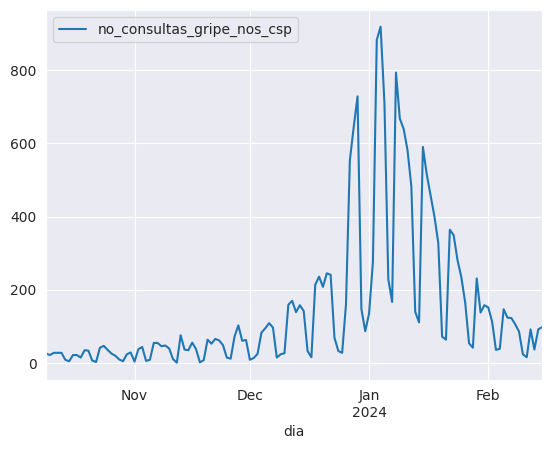

In [104]:
#Visualização rápida dos dados
df.plot()

In [105]:
#Estatisticas descritivas sobre os dados
df.describe()

,no_consultas_gripe_nos_csp
count,130.000000
mean,147.061538
std,199.710983
min,1.000000
25%,28.000000
50%,63.500000
75%,158.750000
max,918.000000


**Notas:**

* Assimetria nos dados: A média (173.19) é maior que a mediana (92), sugerindo uma distribuição assimétrica à direita;

* Alta variabilidade: O desvio padrão (213.65) é muito alto em relação à média, o que indica que os números de consultas variam bastante ao longo do tempo;
* Possível presença de outliers: O valor máximo (918 consultas) é muito maior do que o terceiro quartil (214 consultas), o que pode indicar eventuais picos de gripe (ou erros nos dados);
* Distribuição concentrada em valores baixos: 50% dos registos têm menos de 92 consultas por dia, sugerindo que, na maior parte do tempo, a procura foi baixa.

In [106]:
#Visualização interativa dos dados
fig = px.line(df, x=df.index, y='no_consultas_gripe_nos_csp')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

A seguir, é feita uma análise exploratória inicial à variável que indica o número de consultas por gripe.

É utilizado um histograma (`histplot`) para visualizar a distribuição desta variável. Esta visualização permite perceber a assimetria dos dados, a presença de outliers ou valores extremos, e dá uma ideia geral da dispersão.

Foi também gerado um gráfico de caixa (boxplot), que reforça a análise da distribuição dos número de consultas por gripe, permitindo identificar facilmente os outliers.


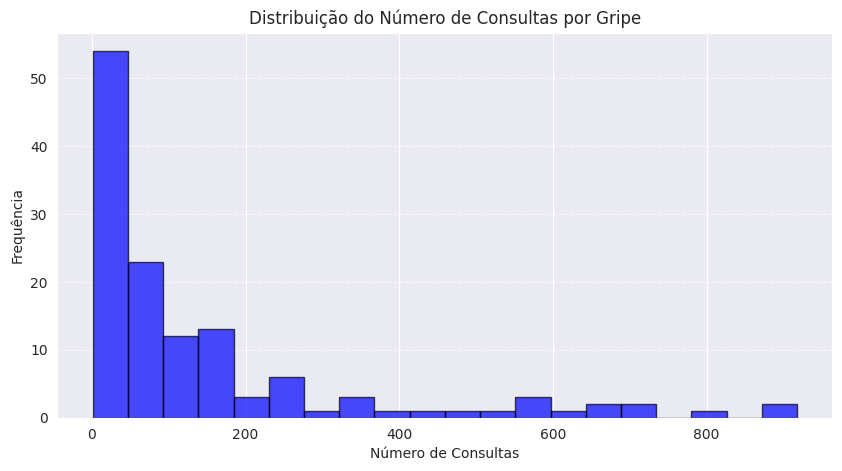

In [107]:
#Distribuição do número de consultas por gripe
def histograma(df):

    plt.figure(figsize=(10,5))
    plt.hist(df['no_consultas_gripe_nos_csp'], bins=20, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel("Número de Consultas")
    plt.ylabel("Frequência")
    plt.title("Distribuição do Número de Consultas por Gripe")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Saída
histograma(df)

**Notas:** No hitograma, observa-se que a maior parte dos valores concentra-se nos escalões mais baixos de número de consultas, o que poderá indicar que eventos de gripe com muitos atendimentos são mais raros. Esta informação pode ser relevante para entender padrões sazonais ou eventuais surtos.

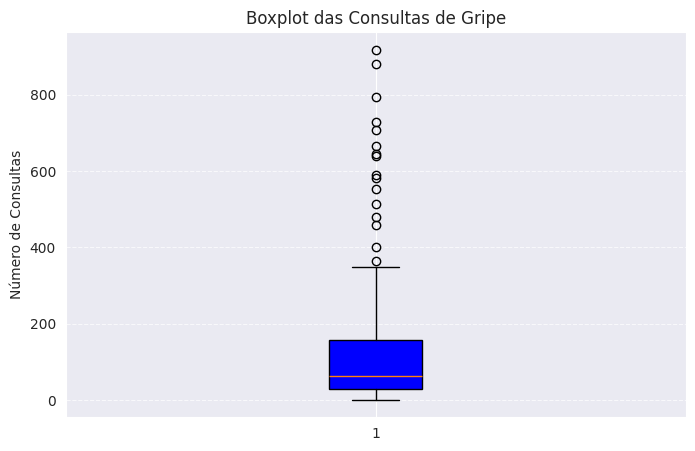

In [108]:
#Visualização dos outliers
def boxplot(df):

    plt.figure(figsize=(8,5))
    plt.boxplot(df['no_consultas_gripe_nos_csp'], vert=True, patch_artist=True, boxprops=dict(facecolor='blue'))
    plt.ylabel("Número de Consultas")
    plt.title("Boxplot das Consultas de Gripe")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Chamando a função
boxplot(df)

É possível verificar que a mediana (linha vermelha) se encontra próxima de valores baixos, o que confirma que a maioria dos registos apresenta um número reduzido de consultas. A caixa mostra que 50% dos dados estão concentrados entre valores relativamente baixos, enquanto a presença de diversos outliers acima dos limites superiores (valores extremos acima de Q3 + 1.5 * IQR) indica a existência de semanas com surtos significativamente mais intensos.

---

Nesta parte, analisamos a distribuição dos registos ao longo dos dias da semana. Utilizamos a função `strftime('%a')` para extrair o nome abreviado do dia da semana a partir do índice da DataFrame.

Em seguida, contabilizamos o número de registos por dia com `value_counts()` e reordenamos o resultado para seguir a ordem cronológica de segunda a domingo, através de `reindex()`.

A visualização é feita com um gráfico de barras, usando `seaborn.barplot`, o que permite uma leitura clara e comparativa entre os dias. O gráfico inclui uma grelha no eixo y para facilitar a perceção das diferenças. Os limites do eixo y foram definidos para realçar as variações (neste caso, entre 15 e 20 registos por dia), permitindo identificar possíveis padrões ou desequilíbrios na recolha de dados ao longo da semana.

Esta análise é importante para validar a consistência temporal do dataset — por exemplo, se há dias sistematicamente sub-representados, isso pode influenciar análises posteriores e precisa de ser considerado.

In [109]:
# Contar o número de registos por dia da semana
dias_da_semana = df.index.strftime('%a').value_counts()

# Reordenar conforme a ordem correta dos dias da semana
ordem_correta = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dias_da_semana = dias_da_semana.reindex(ordem_correta)

# Saída
print(dias_da_semana)

dia
Mon    19
Tue    19
Wed    19
Thu    19
Fri    18
Sat    18
Sun    18
Name: count, dtype: int64


<ipython-input-110-ca7618304846>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




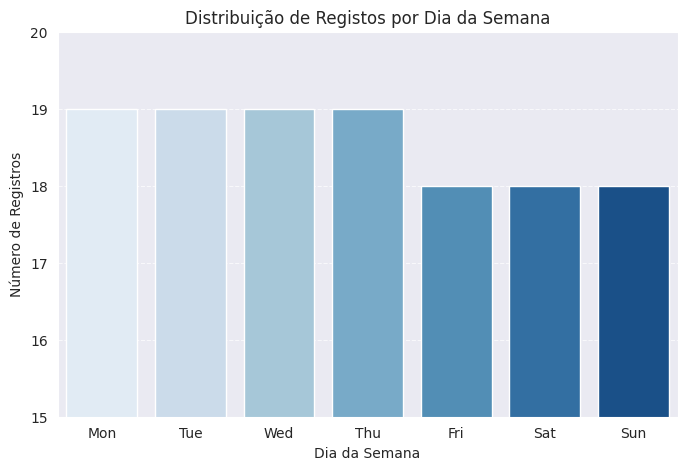

In [110]:
# Contar os registos por dia da semana diretamente do índice
dias_da_semana = df.index.strftime('%a').value_counts()

# Reordenar para manter a sequência correta (Mon → Sun)
ordem_correta = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dias_da_semana = dias_da_semana.reindex(ordem_correta, fill_value=0)

# Gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x=dias_da_semana.index, y=dias_da_semana.values, palette="Blues")
plt.ylim(15, 20)

plt.xlabel("Dia da Semana")
plt.ylabel("Número de Registros")
plt.title("Distribuição de Registos por Dia da Semana")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Saída
plt.show()

**Notas:**

* Segunda-feira (Mon) e Quinta-feira (Thu) têm o maior número de registos (17 dias);

* Sábado (Sat) e Domingo (Sun) têm o menor número de registos (13 e 12 dias, respetivamente), indicando um menor funcionamento dos serviços de saúde nesses dias;
* Os valores são relativamente próximos entre si, indicando que os dados não estão desbalanceados entre os dias da semana.


---

Para melhor entender a tendência subjacente ao número de consultas por gripe, aplicamos o método de suavização LOWESS (Locally Weighted Scatterplot Smoothing).

Este método não paramétrico ajusta uma curva suave aos dados, baseada em regressões locais ponderadas. É particularmente útil em séries temporais ruidosas, onde a tendência não é facilmente captável com médias móveis ou modelos lineares.

- Criamos um vetor `t` representando o tempo (índice sequencial dos registos);
- A variável resposta `y` corresponde ao número de consultas por gripe;
- Aplicamos a função `lowess` da biblioteca `statsmodels`, definindo um parâmetro `frac=0.3`, que indica a fração dos dados usada localmente em cada estimativa — neste caso, 30%.

Por fim, a tendência suavizada é visualizada em conjunto com os dados reais, o que permite perceber oscilações sazonais e padrões de longo prazo, sem perder o detalhe temporal.

Esta abordagem é útil para destacar tendências gerais, sem a rigidez de um modelo estatístico estritamente definido.


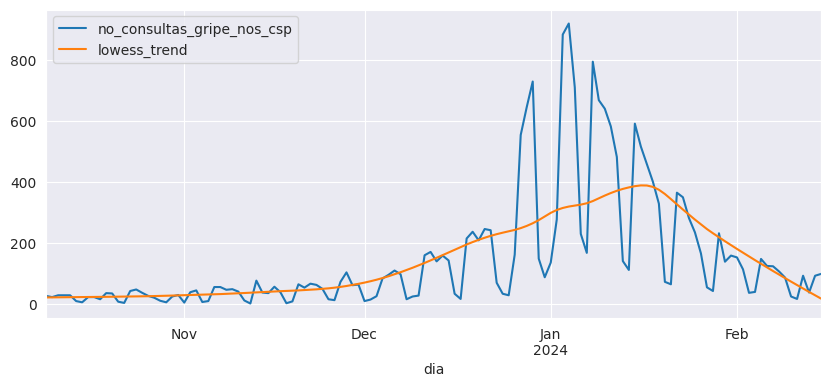

In [111]:
#LOWESS/LOESS (locally weighted scatterplot smoothing)

# Criar regressor
t = [i+1 for i in range(len(df))]

# Definir variável resposta/dependente
y = df.no_consultas_gripe_nos_csp

# Estimar o modelo
# frac - Between 0 and 1. The fraction of the data used when estimating each y-value.
# Default: frac=0.6666666666666666.
frac_value = 0.3
lowess_trend = sm.nonparametric.lowess(y, t, frac=frac_value)[:,1]

# Obter o gráfico
df.assign(lowess_trend=lowess_trend).plot(figsize=(10,4));

**Notas:**

* A série apresenta uma clara tendência de crescimento e queda, com um pico por volta de janeiro de 2024;

* A variação sazonal não é constante – a amplitude das flutuações aumenta com o tempo;
* A linha LOWESS captura bem a tendência geral, mas não detalha a sazonalidade.

## 1.3 Decomposição da série temporal

Nesta secção, é realizada a decomposição da série temporal que representa o número de consultas por gripe ao longo do tempo.

A decomposição é uma técnica fundamental para analisar séries temporais, pois permite separar a série original em três componentes principais:

- **Tendência (trend):** mostra a evolução geral da série ao longo do tempo, indicando se há um aumento ou diminuição sustentada.
- **Sazonalidade (seasonality):** representa padrões que se repetem com frequência regular, como variações semanais, mensais ou anuais.
- **Resíduo (residual):** contém as variações aleatórias que não são explicadas pela tendência nem pela sazonalidade. Pode incluir ruído ou eventos inesperados.

A função utilizada para esta decomposição é `seasonal_decompose` do módulo `statsmodels.tsa.seasonal`.

Com base na análise anterior, conclui-se que a decomposição STL é a melhor escolha, pois permite lidar com variações sazonais não constantes e ajustar melhor a tendência.

In [112]:
# Efetuar a decomposição STL com parâmetros por omissão
decomp_stl = STL(df).fit()
df_decomp_stl = pd.DataFrame({'observed': decomp_stl.observed.squeeze(),
                              'trend': decomp_stl.trend,
                              'seasonal': decomp_stl.seasonal,
                              'residual': decomp_stl.resid})
# Ver parâmetros
STL(df).config

{'period': 7,
 'seasonal': 7,
 'seasonal_deg': 1,
 'seasonal_jump': 1,
 'trend': 15,
 'trend_deg': 1,
 'trend_jump': 1,
 'low_pass': 9,
 'low_pass_deg': 1,
 'low_pass_jump': 1,
 'robust': False}

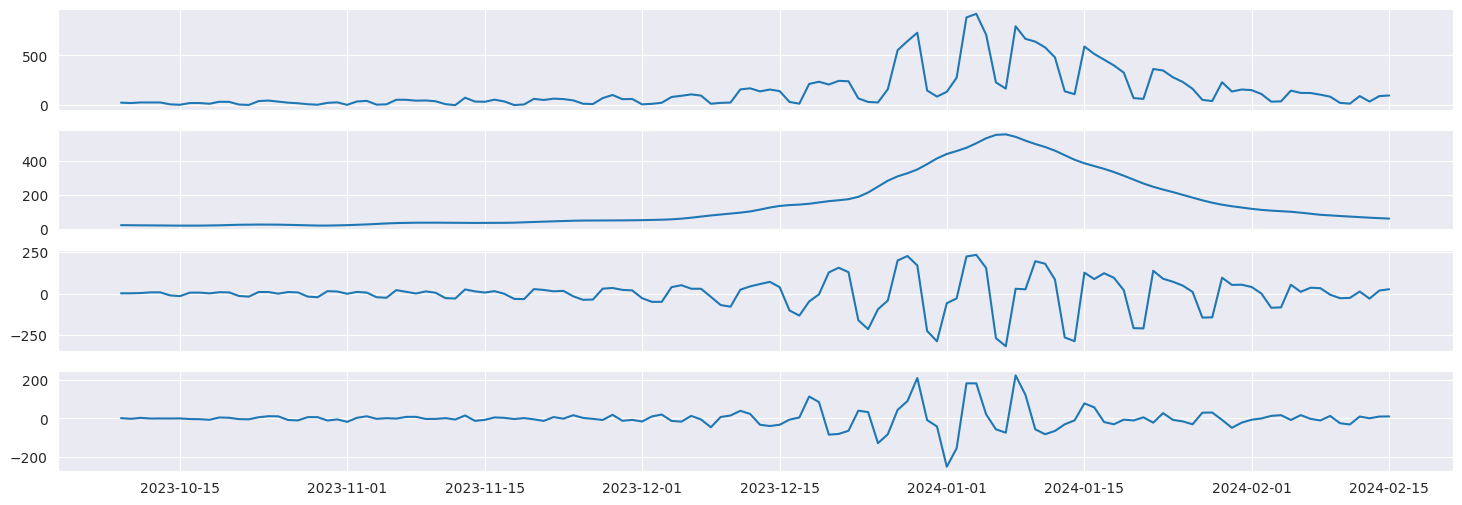

In [113]:
fig, ax = plt.subplots(4, 1, figsize=(18,6), sharex=True)
ax[0].plot(df_decomp_stl.observed)
ax[1].plot(df_decomp_stl.trend)
ax[2].plot(df_decomp_stl.seasonal)
ax[3].plot(df_decomp_stl.residual)
plt.show()

**Notas:**

O gráfico acima mostra os quatro componentes obtidos através da decomposição da série temporal do número de consultas por gripe:

1. **Série original (1º painel):** mostra a evolução real dos dados ao longo do tempo;
2. **Tendência (2º painel):** evidencia uma subida clara no número de consultas entre meados de dezembro e início de janeiro, seguida de uma diminuição gradual. Esta componente está bem definida e capta corretamente a evolução global;
3. **Sazonalidade (3º painel):** revela um padrão oscilatório regular, com ciclos de subida e descida que se repetem, provavelmente associados à periodicidade semanal. A estrutura é consistente e bem delineada, o que indica que a componente sazonal foi adequadamente captada;
4. **Resíduos (4º painel):** contêm as variações aleatórias que não são explicadas pela tendência nem pela sazonalidade. Observa-se uma maior dispersão de resíduos nos períodos de maior atividade gripal, o que é esperado devido à variabilidade acrescida nesses momentos.

A decomposição foi bem-sucedida. A tendência é suavizada e interpretável, a sazonalidade apresenta um padrão lógico e regular, e os resíduos parecem representar ruído aleatório, especialmente fora dos picos. Estes resultados sugerem que a série tem uma estrutura adequada para modelação futura, podendo beneficiar de modelos que considerem explicitamente a sazonalidade, como SARIMA.

Esta análise confirma também a existência de um **padrão sazonal claro** e **um surto gripal bem definido no inverno**, o que é coerente com o comportamento esperado da gripe em contexto real.


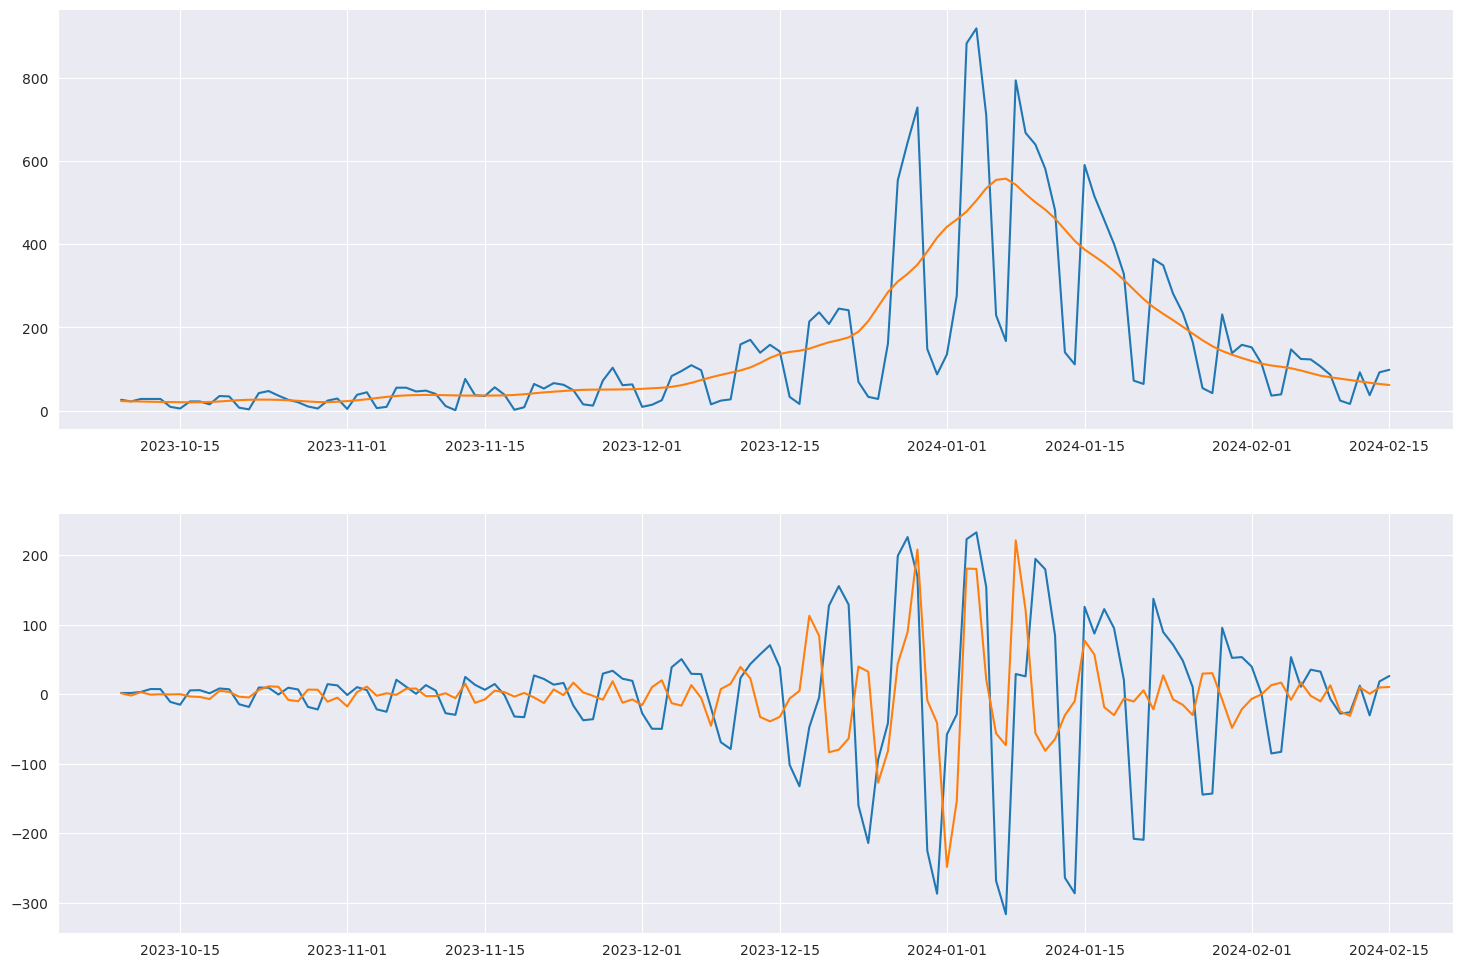

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(18,12))
ax[0].plot(df_decomp_stl.observed)
ax[0].plot(df_decomp_stl.trend)
ax[1].plot(df_decomp_stl.seasonal)
ax[1].plot(df_decomp_stl.residual)
plt.show()

O gráfico acima apresenta uma comparação visual entre a série temporal original (linha azul) e a componente de tendência extraída na decomposição (linha laranja), tanto no nível da série completa (painel superior) como nos resíduos (painel inferior).

No primeiro painel, observa-se que a tendência suaviza os picos da série original, captando eficazmente a evolução geral do número de consultas por gripe ao longo do tempo. Esta linha laranja permite perceber claramente o crescimento gradual até ao pico em janeiro e a posterior descida.

Já no segundo painel, os resíduos (diferença entre a série original e a tendência) oscilam em torno de zero, como esperado. No entanto, nota-se uma maior amplitude durante o período de pico epidémico, o que pode indicar maior variabilidade nos dados nesse período — possivelmente devido a fatores exógenos (como surtos localizados ou variações no registo de dados). Ainda assim, os resíduos mantêm-se simétricos e centrados, o que sugere que a extração da tendência foi eficaz e a decomposição é adequada.

In [115]:
# Obter e visualizar a série ajustada de sazonalidade
df_season_adjusted_stl = df_decomp_stl.assign(seasonadjust = df_decomp_stl.observed - df_decomp_stl.seasonal)
fig = px.line(df_season_adjusted_stl, x=df_season_adjusted_stl.index, y='seasonadjust')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

O gráfico interativo acima representa a série temporal ajustada da sazonalidade, obtida através da remoção do componente sazonal identificado pela decomposição STL. Esta transformação permite analisar a evolução da variável — número de consultas por gripe — sem a influência de padrões sazonais cíclicos, o que ajuda a destacar variações estruturais e tendências mais gerais.

Ao eliminar a sazonalidade, torna-se mais claro o impacto de fenómenos como surtos gripais, já que se removem as flutuações semanais que ocorrem de forma sistemática. A estrutura do pico gripal mantém-se evidente, o que mostra que a tendência geral não era causada apenas por sazonalidade, mas sim por um verdadeiro aumento nos casos.


### Outliers

Nesta parte da análise, foi feita a identificação de possíveis outliers na série temporal — ou seja, observações que se desviam significativamente do comportamento esperado.

Com base na decomposição e visualizações anteriores (como o boxplot e os resíduos), foi possível observar valores extremos, sobretudo durante os períodos de maior incidência de gripe. Esses outliers podem estar associados a surtos intensos, erros de registo ou outras variáveis contextuais não controladas.

A análise dos resíduos revelou que os desvios são mais pronunciados nos momentos de pico, o que é esperado, mas a simetria geral e a concentração em torno de zero indicam que não há grandes distorções estruturais.

No contexto desta análise, os outliers foram interpretados como representativos da realidade e, por isso, mantidos na série, permitindo assim preservar a variabilidade real do fenómeno gripal.

In [116]:
#Cálculo dos outliers

def tukey_fences(df, column):
    Q1 = df.quantile(0.25).loc[column]
    Q3 = df.quantile(0.75).loc[column]
    IQR = Q3 - Q1
    lower_fence = Q1 - 3 * IQR
    upper_fence = Q3 + 3 * IQR
    return lower_fence, upper_fence

def outlier_tukey(df, column):
    lower_fence, upper_fence = tukey_fences(df, column)
    df_outliers = df.query(f'{column} < @lower_fence or {column} > @upper_fence')
    return df_outliers

In [117]:
outliers = outlier_tukey(df_decomp_stl, 'residual')

In [118]:
outliers

,observed,trend,seasonal,residual
dia,,,,
2023-12-18,214,148.686464,-47.501033,112.814569
2023-12-19,236,156.700628,-4.669345,83.968718
2023-12-20,208,164.079243,127.489087,-83.568330
2023-12-25,28,249.644344,-94.296255,-127.348089
2023-12-26,161,284.467499,-41.672192,-81.795306
2023-12-28,644,328.394207,226.211910,89.393883
2023-12-29,728,350.499910,169.306320,208.193769
2024-01-01,135,441.560953,-57.896479,-248.664474
2024-01-02,276,459.016514,-28.958318,-154.058196


Esta tabela apresenta os outliers das componentes resultantes da decomposição STL.

In [119]:
# Destacar os outliers atendendo à magnitude e sentido
cm = sns.color_palette("vlag", as_cmap=True)
outliers.filter(['residual']).style.background_gradient(cmap=cm).format("{:.3}")

,residual
dia,
2023-12-18 00:00:00,1.13e+02
2023-12-19 00:00:00,84.0
2023-12-20 00:00:00,-83.6
2023-12-25 00:00:00,-1.27e+02
2023-12-26 00:00:00,-81.8
2023-12-28 00:00:00,89.4
2023-12-29 00:00:00,2.08e+02
2024-01-01 00:00:00,-2.49e+02
2024-01-02 00:00:00,-1.54e+02


Este heatmap destaca visualmente os resíduos mais extremos, usando uma escala de cores para indicar a magnitude e o sinal dos desvios.

Valores positivos e negativos acentuados aparecem em tons mais intensos (vermelho e azul), tornando fácil identificar os dias com desvios maiores face ao comportamento esperado. Esta abordagem ajuda a localizar rapidamente os outliers, sem necessidade de percorrer toda a tabela manualmente.

In [120]:
# Criar uma dataframe que junte as dataframes da melhor decomposição e dos outliers
decomp_with_outliers = pd.concat([df_decomp_stl,outliers], axis=1)

# Corrigir o nome das quatro últimas colunas
decomp_with_outliers.columns = ['observed', 'trend', 'seasonal', 'residual', 'observed_out', 'trend_out', 'seasonal_out', 'residual_out']

In [121]:
decomp_with_outliers

,observed,trend,seasonal,residual,observed_out,trend_out,seasonal_out,residual_out
dia,,,,,,,,
2023-10-09,26,22.815313,1.765271,1.419417,NaN,NaN,NaN,NaN
2023-10-10,22,22.256059,1.740754,-1.996813,NaN,NaN,NaN,NaN
2023-10-11,28,21.728184,3.266144,3.005672,NaN,NaN,NaN,NaN
2023-10-12,28,21.243129,7.423415,-0.666544,NaN,NaN,NaN,NaN
2023-10-13,28,20.808259,7.324688,-0.132947,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-02-11,16,73.279957,-26.075804,-31.204154,NaN,NaN,NaN,NaN
2024-02-12,92,69.951674,12.248774,9.799553,NaN,NaN,NaN,NaN
2024-02-13,37,66.830652,-30.466679,0.636027,NaN,NaN,NaN,NaN


Nesta tabela acima são adicionadas colunas booleanas que indicam se cada observação foi considerada um outlier, com base nas diferentes componentes.

Neste caso, apenas os outliers identificados nos resíduos foram sinalizados, o que mostra que a deteção foi feita com critério estatístico robusto.

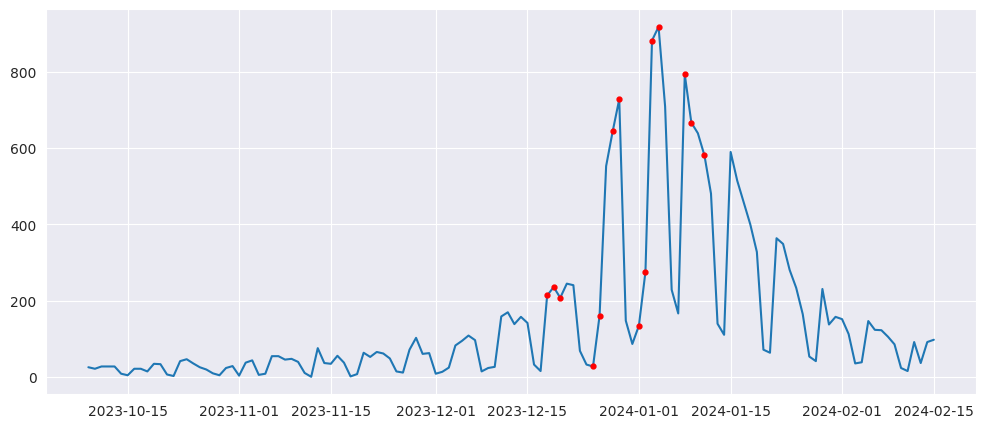

In [122]:
# Visualizar a série com os outliers assinalados
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(decomp_with_outliers.observed)
ax.plot(decomp_with_outliers.observed_out, linestyle='', marker='.', markersize=7, color='red')
plt.show()

Este gráfico mostra a série temporal original, com os outliers identificados marcados a vermelho.

Os pontos vermelhos concentram-se sobretudo no período de maior atividade gripal, validando a análise feita anteriormente. Esta visualização é especialmente útil para compreender o impacto dos outliers em termos temporais e facilita a identificação de padrões incomuns ou picos abruptos.

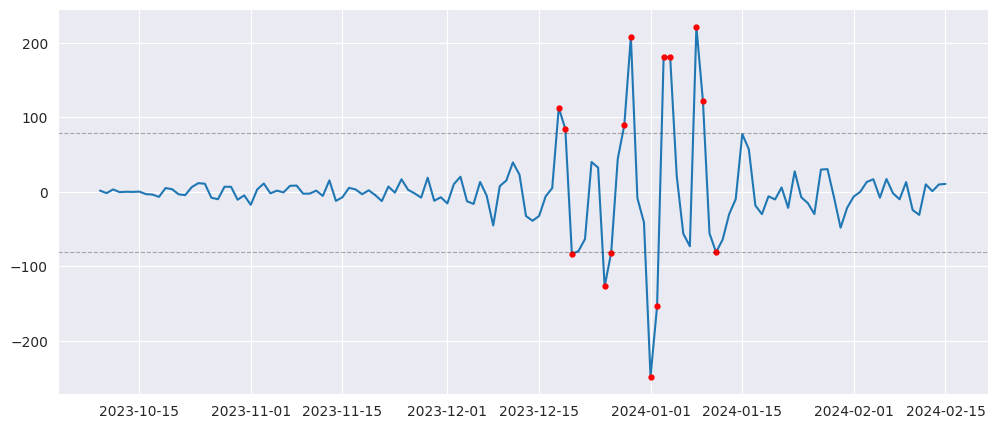

In [123]:
# Visualizar a componente irregular com os outliers assinalados
l_fence, u_fence = tukey_fences(df_decomp_stl, 'residual')

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(decomp_with_outliers.residual)
ax.plot(decomp_with_outliers.residual_out, linestyle='', marker='.', markersize=7, color='red')
ax.axhline(l_fence, color='black', linestyle="--", linewidth=0.8, alpha=0.3)
ax.axhline(u_fence, color='black', linestyle="--", linewidth=0.8, alpha=0.3)
plt.show()

Neste gráfico é apresentada a componente de resíduos, com os outliers assinalados a vermelho e os limites de Tukey (inferior e superior) desenhados como linhas a tracejado.

É uma representação clara da deteção estatística de outliers: sempre que um ponto ultrapassa estes limites, é considerado extremo. A distribuição dos resíduos mostra que a maioria se concentra dentro dos limites, mas alguns valores se destacam de forma significativa — correspondendo aos picos gripais.

In [124]:
# Acrescentar à dataframe decomp_with_outliers, a coluna seasonadjust com os valores da série ajustada de sazonalidade
decomp_with_outliers = decomp_with_outliers\
.assign(seasonadjust = decomp_with_outliers.observed-decomp_with_outliers.seasonal,
        seasonadjust_out = decomp_with_outliers.observed_out-decomp_with_outliers.seasonal_out)

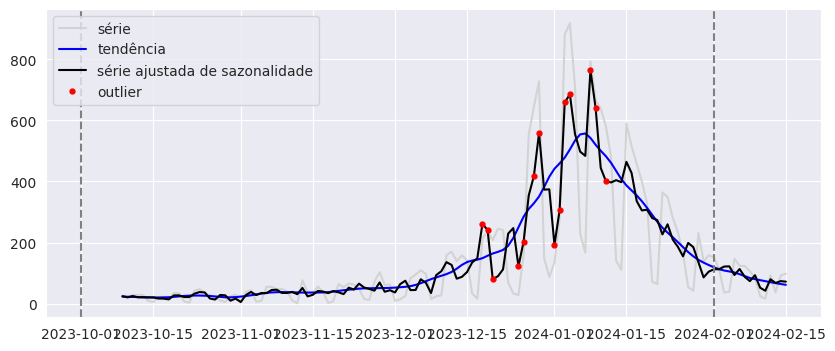

In [125]:
# Fazer um gráfico com a série a cinzento claro, a linha de tendência a azul, a série ajustada de sazonalidade a preto
# e com os outliers assinalados com marcadores vermelhos na série ajustada de sasonalidade
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(decomp_with_outliers.observed, color='lightgray', label='série')
ax.plot(decomp_with_outliers.trend, color='blue', label='tendência')
ax.plot(decomp_with_outliers.seasonadjust, color='black', label='série ajustada de sazonalidade')
ax.plot(decomp_with_outliers.seasonadjust_out, linestyle='', marker='.', markersize=7, color='red', label='outlier')
ax.legend()
ax.axvline(pd.Timestamp('2023-10'), color='gray', linestyle='--')
ax.axvline(pd.Timestamp('2024-02'), color='gray', linestyle='--')
plt.show()

Este gráfico integra várias informações: a série original (cinzento), a tendência (linha azul-escura), a série ajustada de sazonalidade (preto) e os outliers (pontos vermelhos).

Esta representação final permite uma análise muito rica: observa-se claramente que os outliers ocorrem em desvios relevantes face à tendência e à componente ajustada. É uma forma eficaz de contextualizar os outliers no comportamento geral da série, mostrando que não são simples ruídos, mas reflexos de variações reais, provavelmente associadas a surtos gripais.

# _2. Previsões para os sete dias seguintes ao dia mais recente disponível deste conjunto de dados

> **Apresentação:**
1. Definição clara das previsões objetivo
2. Relato das etapas efetuadas no notebook com justificações

## 2.1 Preparação dos dados


Nesta fase, preparamos os dados no formato exigido pela biblioteca **StatsForecast**, que será utilizada nas secções seguintes para ajuste de modelos preditivos.

O DataFrame `Y_df` é construído a partir dos dados originais, seguindo a estrutura padrão exigida para séries temporais multivariadas nesta biblioteca:

- A coluna **`unique_id`** identifica a série (neste caso, há apenas uma série — "consultas").
- A coluna **`ds`** representa a variável temporal (data), renomeada a partir de `dia`.
- A coluna **`y`** corresponde à variável dependente — o número de consultas por gripe — renomeada para seguir o padrão da biblioteca.
- O índice é **resetado** para garantir compatibilidade com métodos que exigem DataFrame com índice numérico.
- Garante-se que a coluna `ds` está no formato **datetime**, necessário para ordenação e visualizações corretas.
- Por fim, os dados são ordenados por data (`sort_values`) para preservar a coerência temporal.

In [126]:
Y_df = (
    df
    .assign(unique_id='consultas')
    .reset_index()
    .rename(columns={'dia': 'ds'})
    .rename(columns={'no_consultas_gripe_nos_csp': 'y'})
    .filter(['unique_id', 'ds', 'y'])
    .assign(ds=lambda x: pd.to_datetime(x['ds']))
    .sort_values('ds')
)
# Display the first 5 rows of the dataframe
Y_df.head()

,unique_id,ds,y
0,consultas,2023-10-09,26
1,consultas,2023-10-10,22
2,consultas,2023-10-11,28
3,consultas,2023-10-12,28
4,consultas,2023-10-13,28


In [127]:
StatsForecast.plot(Y_df, engine='plotly')

## 2.2 Separação treino/teste

Para avaliar o desempenho preditivo dos modelos de forma realista, é essencial dividir os dados em dois subconjuntos: **treino** (para ajustar o modelo) e **teste** (para validar a capacidade de generalização).

A separação foi feita com base numa **data fixa** — 8 de fevereiro de 2024 (`cutoff_date`). Essa abordagem respeita a natureza temporal da série, impedindo que o modelo "veja" dados futuros, o que seria irrealista e levaria a overfitting.

- As observações **até à data de corte** foram atribuídas ao conjunto de treino (`train_df`).
- As observações **após essa data** formam o conjunto de teste (`test_df`).

Esta divisão é depois visualizada num gráfico de linha, onde:
- A série de treino é representada a azul;
- A série de teste, a vermelho;
- A data de corte é marcada com uma linha tracejada cinzenta.

In [128]:
# Data fixa para separar treino e teste
cutoff_date = '2024-02-08'
# Dados até à data de corte vão para treino
train_df = Y_df[Y_df['ds'] <= cutoff_date].copy()

# Dados após a data de corte vão para teste
test_df = Y_df[Y_df['ds'] > cutoff_date].copy()
print(f"Tamanho do conjunto de treino: {len(train_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

print("Intervalo do treino:", train_df['ds'].min(), "→", train_df['ds'].max())
print("Intervalo do teste :", test_df['ds'].min(), "→", test_df['ds'].max())

Tamanho do conjunto de treino: 123
Tamanho do conjunto de teste: 7
Intervalo do treino: 2023-10-09 00:00:00 → 2024-02-08 00:00:00
Intervalo do teste : 2024-02-09 00:00:00 → 2024-02-15 00:00:00


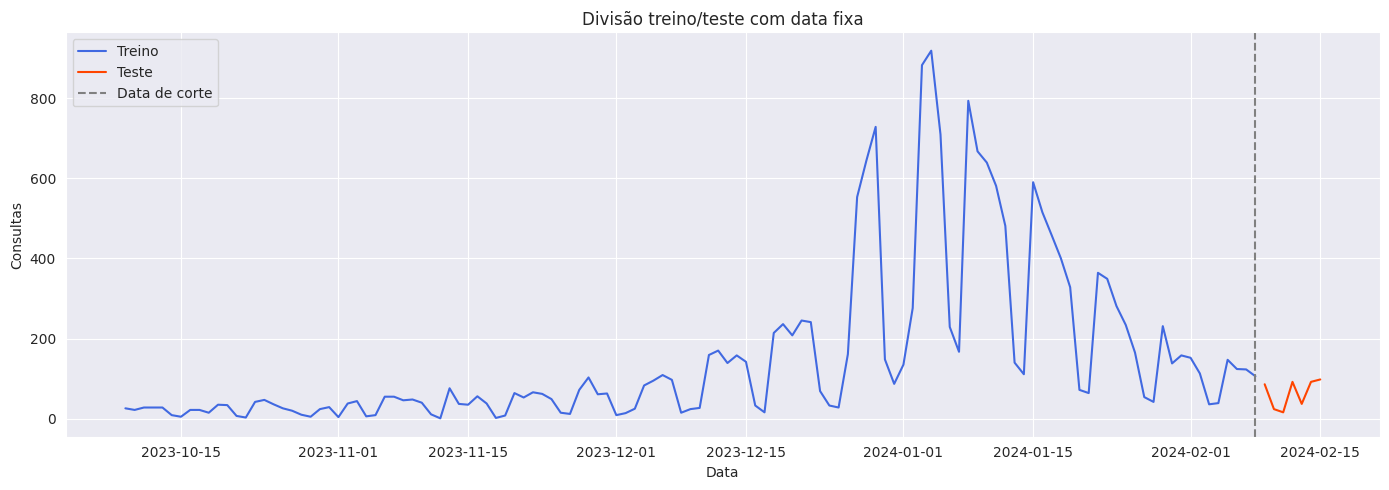

In [129]:
plt.figure(figsize=(14, 5))
plt.plot(train_df['ds'], train_df['y'], label='Treino', color='royalblue')
plt.plot(test_df['ds'], test_df['y'], label='Teste', color='orangered')
plt.axvline(pd.to_datetime(cutoff_date), color='gray', linestyle='--', label='Data de corte')
plt.xlabel('Data')
plt.ylabel('Consultas')
plt.title('Divisão treino/teste com data fixa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.3 Seleção dos métodos de previsão e medidas de avaliação

Nesta fase, são definidos os modelos que serão utilizados para previsão da série temporal. A seleção inclui abordagens variadas, com diferentes estratégias de modelação e decomposição, o que permite uma comparação robusta entre métodos.

A **sazonalidade** foi definida como 7 dias, assumindo um padrão semanal nas consultas por gripe, de acordo com as análises anteriores.

A lista de modelos inclui:

- **SeasonalNaive (MSS):** um modelo simples que assume que o valor futuro será igual ao observado na mesma posição do ciclo anterior (por exemplo, o valor da semana passada).
- **AutoETS:** modelo de alisamento exponencial (Error, Trend, Seasonality), em que a estrutura (aditiva, multiplicativa, etc.) é escolhida automaticamente. É eficaz para séries com tendência e sazonalidade bem definidas.

- **AutoARIMA:** modelo clássico de séries temporais que combina autorregressão, integração e média móvel, ajustando os parâmetros automaticamente. É uma boa escolha para séries com padrões temporais complexos.

- **MSTL:** modelo baseado na decomposição *Multiple Seasonal-Trend Loess*, ideal para séries com múltiplas componentes sazonais. Aqui, é combinado com um AutoARIMA para modelar a tendência.

Estes modelos são instanciados e agregados na classe `StatsForecast`, com a frequência temporal da série definida como diária (`freq='D'`), preparando o ambiente para o treino e comparação entre métodos.

Esta diversidade de modelos permite avaliar tanto abordagens simples como métodos mais avançados de decomposição e previsão, ajustados à estrutura da série.

In [130]:
s_length = 7

model_list = [
    SeasonalNaive(season_length=s_length, alias='MSS'),
    AutoETS(season_length=s_length, model='ZZZ', alias='autoETS'),
    AutoARIMA(season_length=s_length, d=None, trace=False, alias='autoARIMA'),
    MSTL(season_length=s_length, trend_forecaster=AutoARIMA())
]

sf = StatsForecast(models=model_list, freq='D')

## 2.4 Treino e avaliação da capacidade preditiva

Nesta etapa, é avaliada a performance preditiva dos modelos definidos anteriormente através de validação cruzada. O treino dos modelos é realizado implicitamente dentro da função `cross_validation`, que ajusta os modelos em múltiplos pontos da série temporal e calcula previsões para os 7 dias seguintes (`h=7`), ao longo de 10 janelas (`n_windows=10`).

Esta estratégia permite testar a capacidade de generalização dos modelos ao longo do tempo, proporcionando uma avaliação mais robusta do que uma simples divisão treino/teste.

Após gerar as previsões, a performance dos modelos é avaliada com diferentes métricas:
- **MAE (Mean Absolute Error):** média dos erros absolutos, fácil de interpretar e resistente a outliers.
- **RMSE (Root Mean Squared Error):** penaliza mais fortemente grandes erros, dando maior peso a previsões imprecisas.
- **MAPE (Mean Absolute Percentage Error):** expressa o erro em termos percentuais, útil para comparações relativas, embora sensível a valores muito baixos.

Esta avaliação quantitativa é fundamental para selecionar o modelo com melhor desempenho para previsões futuras. A utilização de múltiplas métricas garante uma análise mais equilibrada, já que cada métrica capta diferentes aspetos do erro.

In [131]:
crossvalidation_df = sf.cross_validation(
    df=Y_df,
    h=7,
    n_windows=10
)

In [132]:
sf.plot(Y_df, crossvalidation_df.drop(columns=['y','cutoff']), engine='plotly')

In [133]:
mae(crossvalidation_df, models=['MSS', 'autoETS', 'autoARIMA', 'MSTL'])

,unique_id,MSS,autoETS,autoARIMA,MSTL
0,consultas,37.514286,58.739803,24.518639,78.104225


In [134]:
evaluate(
    crossvalidation_df,
    models=['MSS', 'autoETS', 'autoARIMA', 'MSTL'],
    metrics=[rmse, mae, mape],
    ).round(4)

,unique_id,metric,MSS,autoETS,autoARIMA,MSTL
0,consultas,rmse,46.372700,81.355400,33.074902,89.071701
1,consultas,mae,37.514301,58.739799,24.518600,78.104202
2,consultas,mape,0.535100,0.645300,0.521300,1.489400


Com base nestes valores escolhemos o modelo autoARIMA porque apresenta o menor erro nas previsões (com o menor RMSE, MAE e MAPE). Ou seja, é o modelo que consegue fazer melhores previsões.

## 2.5 Reajuste do modelo e análise do diagnóstico de resíduos

Após identificar o modelo com melhor desempenho na validação cruzada (neste caso, o `AutoARIMA`), procedemos ao seu reajuste final sobre o conjunto completo de treino. Com o modelo ajustado, é possível gerar previsões (`forecast`) e obter os valores ajustados (`fitted`), permitindo calcular os resíduos — isto é, a diferença entre os valores observados e os valores ajustados.

A análise dos resíduos é fundamental para validar a adequação do modelo. Idealmente, os resíduos devem comportar-se como ruído branco: estarem centrados em torno de zero, não apresentarem autocorrelação significativa e seguirem (aproximadamente) uma distribuição normal. Abaixo, analisamos essas três propriedades com diferentes visualizações.


In [135]:
best_model = [AutoARIMA(season_length=7, alias='autoARIMA')]

sf_best = StatsForecast(models=best_model, freq='D')

In [136]:
final_forecasts_df = sf_best.forecast(df=train_df, h=7, fitted=True, level=[80, 95])


In [137]:
fitted = sf_best.forecast_fitted_values()

In [138]:
residuals = fitted.merge(train_df, on=['unique_id', 'ds'], how='inner')
residuals['resid'] = train_df['y'] - residuals['autoARIMA']

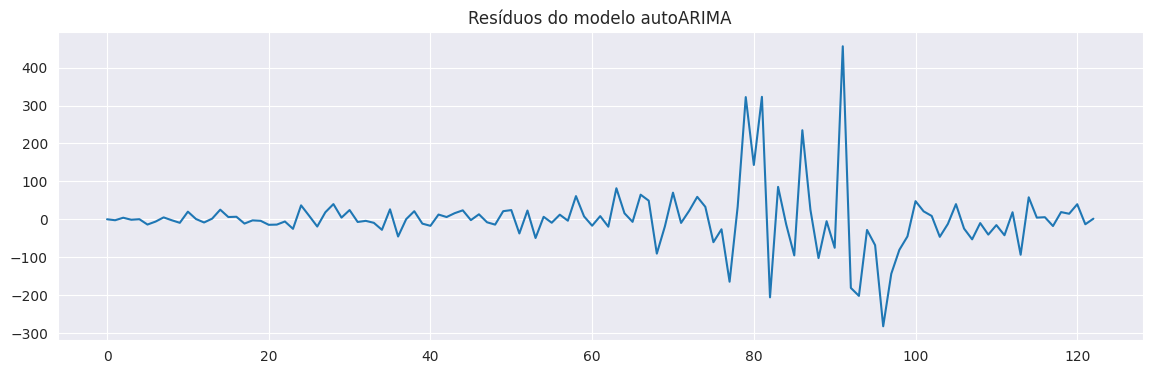

In [139]:
residuals['resid'].plot(figsize=(14, 4), title='Resíduos do modelo autoARIMA')
plt.grid(True)
plt.show()


**Notas:**

Este gráfico mostra a série temporal dos resíduos do modelo `AutoARIMA`.

Observa-se que a maioria dos resíduos está próxima de zero, com algumas oscilações mais acentuadas em períodos específicos, nomeadamente junto ao pico gripal. Embora haja alguma variabilidade, não se nota um padrão sistemático evidente, o que é um bom sinal.

Ainda assim, a presença de alguns resíduos extremos pode indicar que certos pontos não foram totalmente explicados pelo modelo — algo esperado numa série com eventos epidémicos pontuais.

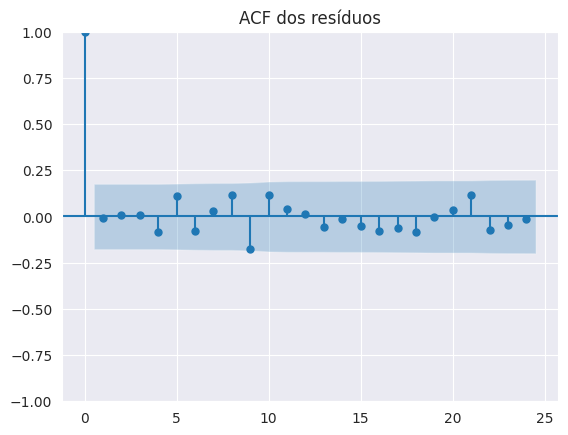

In [140]:
plot_acf(residuals['resid'], lags=24)
plt.title('ACF dos resíduos')
plt.show()


**Notas:**

O gráfico de ACF (Função de Autocorrelação) dos resíduos permite verificar se existem padrões temporais não captados pelo modelo.

Neste caso, quase todos os valores de autocorrelação estão dentro da banda de confiança (área azul), o que indica que não existe autocorrelação significativa
entre os resíduos. Este é um bom indicador de que o modelo captou adequadamente a dependência temporal da série.

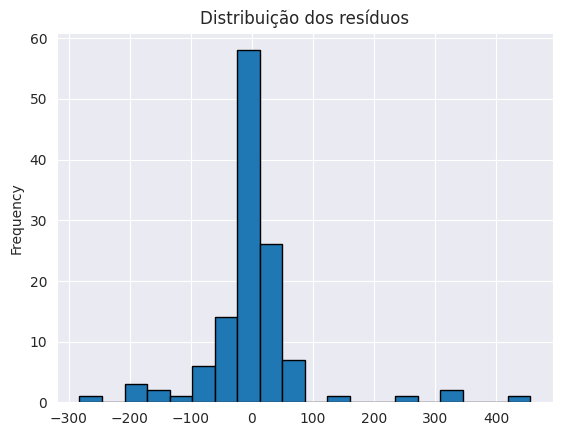

In [141]:
residuals['resid'].plot.hist(bins=20, edgecolor='black', title='Distribuição dos resíduos')
plt.grid(True)
plt.show()

**Notas:**

O histograma dos resíduos mostra a sua distribuição empírica.

Observa-se uma forma aproximadamente simétrica e centrada em torno de zero, com um pico acentuado, mas com alguma assimetria e valores extremos, o que é típico em séries reais com eventos sazonais como surtos gripais.

Embora não seja perfeitamente normal, a distribuição dos resíduos é aceitável para efeitos de previsão, especialmente considerando que não há autocorrelação significativa.

## 2.6 Previsões objetivo com intervalos de previsão

Nesta etapa, são apresentadas as previsões finais do modelo AutoARIMA, agora aplicadas à totalidade dos dados de treino, com foco na previsão para os 7 dias seguintes ao período observado.


In [142]:
final_forecasts_df

,unique_id,ds,autoARIMA,autoARIMA-lo-95,autoARIMA-lo-80,autoARIMA-hi-80,autoARIMA-hi-95
0,consultas,2024-02-09,83.373390,-86.643250,-27.794514,194.541306,253.390030
1,consultas,2024-02-10,49.510460,-163.027267,-89.460487,188.481415,262.048187
2,consultas,2024-02-11,64.901855,-152.595276,-77.311874,207.115585,282.398987
3,consultas,2024-02-12,118.488403,-99.019653,-23.732471,260.709290,335.996460
4,consultas,2024-02-13,118.327141,-99.729301,-24.252306,260.906586,336.383575
5,consultas,2024-02-14,103.617287,-121.261978,-43.423363,250.657928,328.496552
6,consultas,2024-02-15,87.938919,-151.089203,-68.353165,244.231003,326.967041


In [143]:
sf.plot(Y_df,final_forecasts_df, level=[80,95], engine='plotly')

A função `sf.plot(...)` é utilizada para visualizar a série histórica (`Y_df`) juntamente com as previsões geradas (`final_forecasts_df`) e respetivos intervalos de confiança:
- A linha roxa representa a previsão pontual (`autoARIMA`);
- As faixas sombreadas representam os intervalos de previsão a 80% e 95% (mais claro e mais escuro, respetivamente).

Estes intervalos de previsão dão uma noção da incerteza associada às previsões. Quanto mais largo o intervalo, maior a incerteza do modelo sobre os valores futuros. Aqui, os intervalos estão relativamente ajustados ao redor das previsões, o que indica um modelo relativamente confiante.

É importante notar que:
- A previsão é coerente com o padrão decrescente do final da série;
- Não se observam grandes variações inesperadas nos valores previstos;
- O modelo mantém a suavidade característica da sua natureza estatística (ARIMA), sem exagerar ruído.

A visualização final resume a capacidade preditiva do modelo e ajuda a comunicar resultados de forma intuitiva, com indicação da margem de erro esperada.

# _3. Previsões para organização diária do serviço

> **Apresentação:**
1. Definição clara das previsões objetivo
2. Relato das etapas efetuadas no notebook com justificações

Nesta secção foi desenvolvido um processo automatizado de previsão diária, respeitando os seguintes requisitos operacionais:

- **Disponibilidade dos dados**: os dados apenas ficam disponíveis até ao penúltimo dia, dado que o sistema é atualizado diariamente às 18h com o valor do dia D-2.
- **Janela operacional**: o script garante que as previsões só são executadas entre as 9h e as 17h, validando o horário atual.
- **Horizonte de previsão mínimo (h=1)**: prevemos apenas o dia seguinte, otimizando a utilidade operacional imediata da previsão.
- **Modelo consistente com as secções anteriores**: `autoARIMA`.
- **Validação cruzada** incluída para testar a robustez dos modelos com base em janelas recentes de previsão diária.
- **Avaliação com métricas padronizadas**: RMSE, MAE e MAPE foram utilizadas para comparar o desempenho dos modelos.
- **Visualização e interpretação final**: a previsão diária é apresentada em formato de gráfico de barras para facilitar a comparação dos valores previstos por modelo.

Através deste processo, é possível realizar uma previsão automática e fiável todos os dias úteis, com base nos dados mais recentes disponíveis, respeitando os limites operacionais do sistema.

Como resultado, foi possível verificar que o modelo `autoETS` apresentou o melhor desempenho em termos de erro médio absoluto (MAE) nas previsões diárias de curto prazo. No entanto, a diferença entre modelos pode justificar uma avaliação contínua ao longo do tempo, integrando eventualmente outras abordagens ou ajustando o horizonte de previsão conforme a evolução da disponibilidade dos dados.

In [144]:
# Previsão diária com dados disponíveis até ao penúltimo dia

hoje = pd.to_datetime(datetime.today())
penultimo_dia = hoje - timedelta(days=2)

dados_disponiveis = Y_df[Y_df['ds'] <= penultimo_dia]

In [145]:
modelos = [
    AutoARIMA(season_length=7, alias='autoARIMA'),
    AutoETS(season_length=7, model='ZZZ', alias='autoETS'),
    SeasonalNaive(season_length=7, alias='MSS')
]

sf_diario = StatsForecast(models=modelos, freq='D')

In [146]:
previsao_curta = sf_diario.forecast(df=dados_disponiveis, h=1, level=[80, 95])
previsao_curta

,unique_id,ds,autoARIMA,autoARIMA-lo-95,autoARIMA-lo-80,autoARIMA-hi-80,autoARIMA-hi-95,autoETS,autoETS-lo-95,autoETS-lo-80,autoETS-hi-80,autoETS-hi-95,MSS,MSS-lo-80,MSS-lo-95,MSS-hi-80,MSS-hi-95
0,consultas,2024-02-16,72.997208,-93.901283,-36.131851,182.126266,239.895691,58.077538,4.615285,23.120449,93.034622,111.539787,86.0,-82.475479,-171.661011,254.475479,343.661011


In [147]:
# Validação cruzada e avaliação de desempenho

cv_diario = sf_diario.cross_validation(df=dados_disponiveis, h=1, n_windows=10)

avaliacao_diaria = evaluate(
    cv_diario,
    models=['autoARIMA', 'autoETS', 'MSS'],
    metrics=[rmse, mae, mape]  # Use the imported functions here
).round(4)

avaliacao_diaria

,unique_id,metric,autoARIMA,autoETS,MSS
0,consultas,rmse,32.675499,24.690701,40.691502
1,consultas,mae,23.828501,19.037701,33.799999
2,consultas,mape,0.598200,0.271700,0.645100


In [148]:
agora = datetime.now().time()

# Verificar se estamos entre as 9h e as 17h
if agora >= datetime.strptime("09:00", "%H:%M").time() and agora <= datetime.strptime("17:00", "%H:%M").time():
    print("Dentro do horário permitido. A correr previsões...")
else:
    print("Fora do horário permitido (9h–17h). Não foi feita previsão.")

Fora do horário permitido (9h–17h). Não foi feita previsão.


In [149]:
# Reestruturar o dataframe para long format
previsao_melt = previsao_curta.melt(id_vars='ds', value_vars=['autoARIMA', 'autoETS', 'MSS'],
                                     var_name='modelo', value_name='valor')

# Gráfico de barras
px.bar(previsao_melt, x='modelo', y='valor', title='Previsão por modelo para o próximo dia')

In [150]:
# prever mais dias se quiseres ver uma linha
previsao_curta = sf_diario.forecast(df=dados_disponiveis, h=7, level=[80, 95])

# transformar em formato long
previsao_long = previsao_curta.melt(id_vars='ds', value_vars=['autoARIMA', 'autoETS', 'MSS'],
                                    var_name='modelo', value_name='valor')

# gráfico de linhas
px.line(previsao_long, x='ds', y='valor', color='modelo', title='Previsão para os próximos dias')


In [152]:
print(f"Previsão gerada para o dia: {previsao_curta['ds'].iloc[0].date()}")


Previsão gerada para o dia: 2024-02-16


**Notas:**

Este gráfico de linhas apresenta a previsão dos próximos 7 dias feita pelos três modelos considerados: `AutoARIMA`, `AutoETS` e `MSS`.

É possível observar diferenças significativas no comportamento entre os modelos:
- O modelo `MSS` (Seasonal Naive) mostra maior variação e previsões mais elevadas em determinados dias, refletindo diretamente valores anteriores do ciclo semanal.
- O `AutoETS` apresenta previsões mais suavizadas e estáveis, com menos oscilação.
- O `AutoARIMA` segue uma trajetória semelhante ao `ETS`, mas com ligeiras diferenças, mantendo previsões mais conservadoras.

De um modo geral, entre os dias 17, 18 e 20 haverá um descréscimo no número de consultas por gripe, que volta a subir no dia 19, 21 e 22, sendo o mínimo previsto um total de 2 consultas no dia 18 (segundo o autoARIMA), e máximo de 98 consultas segundo o MSS.